<a href="https://colab.research.google.com/github/VardhanVelamakanni/Brain-Tumor-GeneticAlgorithm-SVM-CNN/blob/main/Brain_Tumor(SVM%2CCNN%2CGA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile

zip_path = "/content/drive/MyDrive/dataset/archive (1).zip"
extract_to = "/content/drive/MyDrive/xray_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("✅ ZIP extracted successfully!")

✅ ZIP extracted successfully!


In [3]:
# STEP 0: Install requirements
!pip install deap opencv-python-headless scikit-learn tensorflow



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 9.8 MB/s eta 0:00:00


In [6]:
import os
import cv2
import numpy as np

def load_images_from_folder(folder_path, image_size=(64, 64)):
    images = []
    labels = []
    label_map = {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

    for label_name in os.listdir(folder_path):
        label_folder = os.path.join(folder_path, label_name)
        if not os.path.isdir(label_folder):
            continue
        for img_file in os.listdir(label_folder):
            img_path = os.path.join(label_folder, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, image_size)
                img = img / 255.0  # Normalize
                images.append(img)
                labels.append(label_map[label_name])

    return np.array(images), np.array(labels)


In [7]:
train_path = "/content/drive/MyDrive/xray_dataset/Training"
X_train, y_train = load_images_from_folder(train_path)

print("Images shape:", X_train.shape)
print("Labels shape:", y_train.shape)


Images shape: (2870, 64, 64)
Labels shape: (2870,)


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# Prepare data
X_train = X_train.reshape(-1, 64, 64, 1)  # Add channel dimension
y_train_cat = to_categorical(y_train, num_classes=4)

# Build model
input_layer = Input(shape=(64, 64, 1))
x = Conv2D(16, (3,3), activation='relu')(input_layer)
x = MaxPooling2D()(x)
x = Conv2D(32, (3,3), activation='relu')(x)
x = MaxPooling2D()(x)
x = Flatten()(x)
feature_layer = Dense(64, activation='relu', name="feature_layer")(x)
output_layer = Dense(4, activation='softmax')(feature_layer)

cnn_model = Model(inputs=input_layer, outputs=output_layer)

# Compile and train
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train, y_train_cat, epochs=5, batch_size=32, verbose=1)


Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.4759 - loss: 1.1589
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - accuracy: 0.7046 - loss: 0.7155
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.7707 - loss: 0.5835
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - accuracy: 0.8065 - loss: 0.4941
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - accuracy: 0.8502 - loss: 0.3878


In [9]:
# Create a new model that outputs from the "feature_layer"
feature_extractor = Model(inputs=cnn_model.input, outputs=cnn_model.get_layer("feature_layer").output)

# Extract deep features
cnn_features = feature_extractor.predict(X_train)

print("CNN Feature shape:", cnn_features.shape)  # should be (num_samples, 64)


90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
CNN Feature shape: (2870, 64)


In [10]:
from deap import base, creator, tools, algorithms
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
import random
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Prepare GA environment
num_features = cnn_features.shape[1]  # should be 64

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=num_features)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Fitness function
def evalFitness(individual):
    indices = [i for i, bit in enumerate(individual) if bit == 1]
    if len(indices) == 0:
        return 0.0,
    X_selected = cnn_features[:, indices]
    clf = SVC(kernel='linear')
    accuracy = cross_val_score(clf, X_selected, y_train, cv=3).mean()
    return accuracy,

toolbox.register("evaluate", evalFitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)


In [11]:
# Run GA
pop = toolbox.population(n=10)  # small pop for quick test
NGEN = 5  # few generations to keep it fast

print("[INFO] Running GA... please wait...")

result_pop, _ = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=NGEN, verbose=True)

# Get best individual
top_individual = tools.selBest(result_pop, k=1)[0]
selected_indices = [i for i, bit in enumerate(top_individual) if bit == 1]

print("\n[INFO] Selected Features:", selected_indices)
print("[INFO] Number of selected features:", len(selected_indices))


[INFO] Running GA... please wait...
gen	nevals
0  	10    
1  	4     
2  	4     
3  	6     
4  	3     
5  	6     

[INFO] Selected Features: [2, 3, 4, 7, 8, 9, 13, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 33, 35, 36, 37, 38, 39, 42, 43, 46, 47, 55, 56, 57, 58, 59, 60, 63]
[INFO] Number of selected features: 35


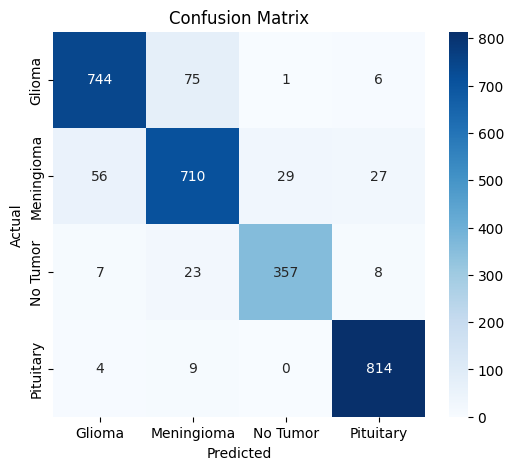

              precision    recall  f1-score   support

      Glioma       0.92      0.90      0.91       826
  Meningioma       0.87      0.86      0.87       822
    No Tumor       0.92      0.90      0.91       395
   Pituitary       0.95      0.98      0.97       827

    accuracy                           0.91      2870
   macro avg       0.92      0.91      0.91      2870
weighted avg       0.91      0.91      0.91      2870



In [12]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare feature subset
X_selected = cnn_features[:, selected_indices]

# Train SVM
clf = SVC(kernel='linear')
clf.fit(X_selected, y_train)

# Predict on training set (for now)
y_pred = clf.predict(X_selected)

# Confusion Matrix
cm = confusion_matrix(y_train, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Glioma', 'Meningioma', 'No Tumor', 'Pituitary'],
            yticklabels=['Glioma', 'Meningioma', 'No Tumor', 'Pituitary'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print(classification_report(y_train, y_pred, target_names=['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']))


In [20]:
test_path = "/content/drive/MyDrive/xray_dataset/Testing"  # Update path if needed


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


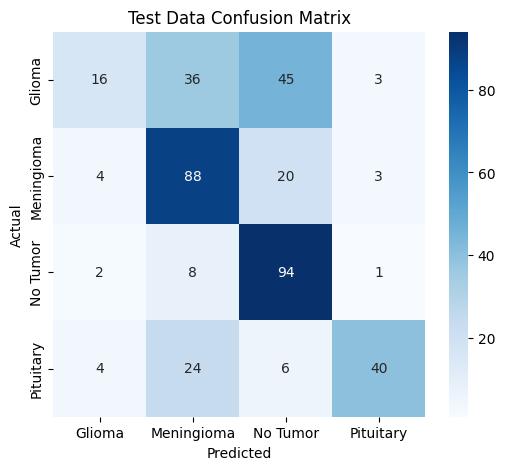

              precision    recall  f1-score   support

      Glioma       0.62      0.16      0.25       100
  Meningioma       0.56      0.77      0.65       115
    No Tumor       0.57      0.90      0.70       105
   Pituitary       0.85      0.54      0.66        74

    accuracy                           0.60       394
   macro avg       0.65      0.59      0.57       394
weighted avg       0.63      0.60      0.56       394



In [21]:
# Extract features from test images
X_test, y_test = load_images_from_folder(test_path)
X_test = X_test.reshape(-1, 64, 64, 1)
test_features = feature_extractor.predict(X_test)

# Apply the same GA-selected feature mask
X_test_selected = test_features[:, selected_indices]

# Predict on test data
y_test_pred = clf.predict(X_test_selected)

# Evaluate
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Glioma', 'Meningioma', 'No Tumor', 'Pituitary'],
            yticklabels=['Glioma', 'Meningioma', 'No Tumor', 'Pituitary'])
plt.title("Test Data Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(y_test, y_test_pred, target_names=['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']))


In [23]:
from google.colab import files
from PIL import Image
import io

def preprocess_single_image(img_path, size=(64, 64)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, size)
    img = img / 255.0
    img = img.reshape(1, 64, 64, 1)
    return img

def predict_tumor_class(img_path):
    # Step 1: Preprocess
    img = preprocess_single_image(img_path)

    # Step 2: Extract CNN features
    features = feature_extractor.predict(img)

    # Step 3: Apply GA-selected features
    selected = features[:, selected_indices]

    # Step 4: Predict using SVM
    pred = clf.predict(selected)[0]
    class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

    return class_names[pred]

# Upload image
uploaded = files.upload()

for fname in uploaded.keys():
    prediction = predict_tumor_class(fname)
    print(f"\nPredicted Tumor Type: {prediction}")


Saving m (7).jpg to m (7).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

Predicted Tumor Type: Meningioma


In [32]:
from sklearn.metrics import accuracy_score

svm_test_acc = accuracy_score(y_test, y_test_pred)
print(f"SVM Test Accuracy: {svm_test_acc:.4f}")


SVM Test Accuracy: 0.6041


In [16]:
# Create individual structure: [conv1_filters, conv2_filters, dense_units, dropout_rate, learning_rate]
import random
from deap import base, creator, tools, algorithms
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import SeparableConv2D


X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train_cat, test_size=0.2, random_state=42)

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("conv1", random.choice, [8, 16, 32])
toolbox.register("conv2", random.choice, [16, 32, 64])

toolbox.register("dense", random.choice, [32, 64, 128])
toolbox.register("dropout", random.uniform, 0.2, 0.5)
toolbox.register("lr", random.uniform, 0.0001, 0.01)

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.conv1, toolbox.conv2, toolbox.dense, toolbox.dropout, toolbox.lr), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


In [17]:
from tensorflow.keras.layers import SeparableConv2D

def evaluate_cnn(ind):
    # Round and clamp to ensure valid shapes
    conv1 = int(round(ind[0]))
    conv2 = int(round(ind[1]))
    dense = int(round(ind[2]))
    dropout_rate = float(ind[3])
    lr = float(ind[4])

    try:
        model = Sequential()
        model.add(SeparableConv2D(conv1, (3, 3), activation='relu', input_shape=(64, 64, 1)))
        model.add(MaxPooling2D())
        model.add(SeparableConv2D(conv2, (3, 3), activation='relu'))
        model.add(MaxPooling2D())
        model.add(Flatten())
        model.add(Dense(dense, activation='relu'))
        model.add(Dropout(dropout_rate))
        model.add(Dense(4, activation='softmax'))

        opt = Adam(learning_rate=lr)
        model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

        history = model.fit(X_train_split, y_train_split, epochs=3, batch_size=32, verbose=0,
                            validation_data=(X_val, y_val))

        val_acc = history.history['val_accuracy'][-1]
        return val_acc,

    except Exception as e:
        print(f"[ERROR] Invalid params {ind} → {e}")
        return 0.0,


In [18]:
toolbox.register("evaluate", evaluate_cnn)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutPolynomialBounded, eta=0.5, low=[16,32,32,0.2,0.0001], up=[64,128,128,0.5,0.01], indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Run the GA
population = toolbox.population(n=5)
NGEN = 3

print("[INFO] Optimizing CNN with GA...")
best_pop, _ = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=NGEN, verbose=True)

best_cnn_params = tools.selBest(best_pop, k=1)[0]
print("[INFO] Best CNN Parameters:", best_cnn_params)


[INFO] Optimizing CNN with GA...
gen	nevals
0  	5     
1  	4     
2  	2     
3  	3     
[INFO] Best CNN Parameters: [16, 16, 84.17559819895328, 0.4483727568966938, 0.009655378021284211]


In [24]:
# Best params from GA
conv1 = 16
conv2 = 16
dense = 84
dropout_rate = 0.448
lr = 0.0096


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SeparableConv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

final_model = Sequential()
final_model.add(SeparableConv2D(conv1, (3, 3), activation='relu', input_shape=(64, 64, 1)))
final_model.add(MaxPooling2D())
final_model.add(SeparableConv2D(conv2, (3, 3), activation='relu'))
final_model.add(MaxPooling2D())
final_model.add(Flatten())
final_model.add(Dense(dense, activation='relu'))
final_model.add(Dropout(dropout_rate))
final_model.add(Dense(4, activation='softmax'))

opt = Adam(learning_rate=lr)
final_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


In [26]:
final_model.fit(X_train, y_train_cat, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.4360 - loss: 1.1709 - val_accuracy: 0.1655 - val_loss: 2.2519
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.6074 - loss: 0.8462 - val_accuracy: 0.2265 - val_loss: 2.1309
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - accuracy: 0.6560 - loss: 0.7466 - val_accuracy: 0.4826 - val_loss: 1.4696
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - accuracy: 0.6709 - loss: 0.7022 - val_accuracy: 0.6185 - val_loss: 1.0893
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.7426 - loss: 0.6230 - val_accuracy: 0.4791 - val_loss: 1.9282
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.7425 - loss: 0.5732 - val_accuracy: 0.5575 - val_loss: 1.5003
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.7854 - loss: 0.4954 - val_accuracy: 0.4756 - val_loss: 1.8777
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.8118 - loss: 0.4510 - val_accuracy: 0.5383 

In [31]:

from tensorflow.keras.utils import to_categorical

y_test_cat = to_categorical(y_test, num_classes=4)


test_loss, test_acc = final_model.evaluate(X_test, y_test_cat, verbose=1)
cnn_test_acc = test_acc  # Store accuracy for comparison

print(f"\nCNN Test Accuracy: {test_acc:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4479 - loss: 6.7335

CNN Test Accuracy: 0.6142


In [27]:
from google.colab import files
from PIL import Image
import cv2
import numpy as np

def preprocess_image_for_cnn(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (64, 64))
    img = img / 255.0
    img = img.reshape(1, 64, 64, 1)
    return img

def predict_with_final_cnn(img_path):
    img = preprocess_image_for_cnn(img_path)
    pred = final_model.predict(img)
    class_idx = np.argmax(pred)
    class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
    return class_names[class_idx]

# Upload and predict
uploaded = files.upload()

for fname in uploaded.keys():
    prediction = predict_with_final_cnn(fname)
    print(f"\n🧠 Final CNN Prediction: {prediction}")


Saving m (9).jpg to m (9).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step

🧠 Final CNN Prediction: Meningioma


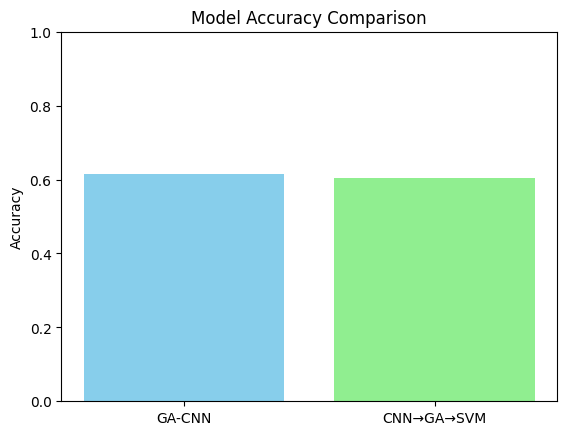

In [33]:
models = ['GA-CNN', 'CNN→GA→SVM']
accuracies = [cnn_test_acc, svm_test_acc]

plt.bar(models, accuracies, color=['skyblue', 'lightgreen'])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.show()
